In [5]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw
#os.chdir('code')
from utils.utils import CustomDataset
from models.model_SE import *
from models.model_ECA import *
from utils.helper import *
import statistics

In [3]:
with open('../data/train.json') as json_data:
    train_data = json.load(json_data)

In [4]:
with open('../data/test.json') as json_data:
    test_data = json.load(json_data)

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
# train data
custom_train_dataset = CustomDataset(train_data, '../data/train', transform=transform)
train_data_loader = torch.utils.data.DataLoader(custom_train_dataset, batch_size=4, shuffle=True, num_workers=0)

# test data
custom_test_dataset = CustomDataset(test_data, '../data/test', transform=None)
test_data_loader = torch.utils.data.DataLoader(custom_test_dataset, batch_size=4, shuffle=True, num_workers=0)

In [11]:
best_prec1 = 0
    

def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    dice_loss = AverageMeter()
    losses_batch = {}
    # switch to train mode
    model.train()

    end = time.time()
    for i, data in enumerate(train_loader):
        
        target = data['annotations']
        input_image = data['image']
        
        # measure data loading time
        data_time.update(time.time() - end)

        if args.gpu is not None:
            input = input.cuda(args.gpu, non_blocking=True)
        target = target.cuda(args.gpu, non_blocking=True)
        
        output = model(input_image)
        
        output_probs = torch.sigmoid(output)
        
        output = output.squeeze(1)  
        output_binary = (output_probs > 0.5).float()

        target = (target > 0).float()
        target = target.squeeze(1)  
        
        loss = criterion(output, target)

        dice = dice_coeff(output_binary, target).item()
        #print('---'*10,'dice', dice,'---'*10)
        
        losses.update(loss.item(), input_image.size(0))
        dice_loss.update(dice, input_image.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print(f"Epoch {epoch}, Loss {loss}, avg. Dice {dice_loss.avg} curr. Dice {dice}")
            print('---'*50)

          
    return losses.avg, dice_loss.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    directory = "runs/%s/"%(args.arch + '_' + args.action)
    
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, directory + 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def dice_coeff(pred, target):
    """
    Calculate the Dice coefficient for batch of predictions and targets.

    Args:
        pred: Predicted tensor of shape (N, C, H, W), where N is the batch size.
        target: Ground truth tensor of shape (N, C, H, W), with the same dimensions as pred.

    Returns:
        dice_score: Computed Dice coefficient.
    """
    smooth = 1.0 

    pred_flat = pred.contiguous().view(pred.size(0), -1)
    target_flat = target.contiguous().view(target.size(0), -1)
    
    intersection = (pred_flat * target_flat).sum(1)  # Sum over the spatial dimensions
    
    #print('pred_flat', pred_flat.sum(1))
    #print('target_flat', target_flat.sum(1))
    
    dice_score = (2. * intersection + smooth) / (pred_flat.sum(1) + target_flat.sum(1) + smooth)
    
    dice_score = dice_score.mean()
    
    return dice_score


def data_save(root, file):
    if not os.path.exists(root):
        os.mknod(root)
    file_temp = open(root, 'r')
    lines = file_temp.readlines()
    if not lines:
        epoch = -1
    else:
        epoch = lines[-1][:lines[-1].index(' ')]
    epoch = int(epoch)
    file_temp.close()
    file_temp = open(root, 'a')
    for line in file:
        if line > epoch:
            file_temp.write(str(line) + " " + str(file[line]) + '\n')
    file_temp.close()

In [12]:
class args():
    gpu = None
    distributed = False
    seed = 42
    pretrained = False
    arch = 'SE_resnet50'
    ksize=None
    lr = 0.01
    momentum = 0.9
    weight_decay = 1e-4
    evaluate = False
    action = ''
    epochs = 100
    start_epoch = 0
    print_freq = 100

In [16]:
global args, best_dice

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')

if args.gpu is not None:
    warnings.warn('You have chosen a specific GPU. This will completely '
                  'disable data parallelism.')


#if args.distributed:
#    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
#                            world_size=args.world_size)

# create model

else:
    print("=> creating model '{}'".format(args.arch))
    if args.ksize == None:
        model = SE_resnet50()
    else:
        model = SE_resnet50(k_size=args.ksize)

if args.gpu is not None:
    model = model.cuda(args.gpu)
    
elif args.distributed:
    model.cuda()
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[0, 1])

else:
    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
    else:
        model = torch.nn.DataParallel(model).cuda()

#print(model)


print('Number of models parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

# define loss function (criterion) and optimizer
#criterion = nn.CrossEntropyLoss().cuda(args.gpu)
criterion = torch.nn.BCEWithLogitsLoss().cuda(args.gpu)


optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

'''# optionally resume from a checkpoint
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
        del checkpoint
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))'''

cudnn.benchmark = True

if args.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
else:
    train_sampler = None

train_loader = train_data_loader

if args.evaluate:
    m = time.time()
    _, _ =validate(val_loader, model, criterion)
    n = time.time()
    print((n-m)/3600)
    

directory = "runs/%s/"%(args.arch + '_' + args.action)
if not os.path.exists(directory):
    os.makedirs(directory)


/tmp/ipykernel_8384/917573791.py:7: UserWarning: You have chosen to seed training. This will turn on the CUDNN deterministic setting, which can slow down your training considerably! You may see unexpected behavior when restarting from checkpoints.
  warnings.warn('You have chosen to seed training. '


=> creating model 'SE_resnet50'
Constructing SE_resnet50......
Number of models parameters: 26018753


In [18]:
Loss_plot = {}
train_dice = {}

for epoch in range(args.start_epoch, args.epochs):
    start_time = time.time()
    if args.distributed:
        train_sampler.set_epoch(epoch)
    adjust_learning_rate(optimizer, epoch)

   
    # train(train_loader, model, criterion, optimizer, epoch)
    loss_temp, dice_ = train(train_loader, model, criterion, optimizer, epoch)
    
    Loss_plot[epoch] = loss_temp
    train_dice[epoch] = dice_

    data_save(directory + 'Loss_plot.txt', Loss_plot)
    data_save(directory + 'train_dice.txt', train_dice)
    

    end_time = time.time()
    time_value = (end_time - start_time) / 3600
    print("-" * 80)
    print(time_value)
    print("-" * 80)

Epoch 0, Loss 33.945396423339844, avg. Dice 0.352155476808548 curr. Dice 0.352155476808548
------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0.00762468761867947
--------------------------------------------------------------------------------
Epoch 1, Loss 1.776419997215271, avg. Dice 0.21869012713432312 curr. Dice 0.21869012713432312
------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0.0028543971644507515
--------------------------------------------------------------------------------
Epoch 2, Loss 0.7916043400764465, avg. Dice 0.11915507912635803 curr. Dice 0.11915507912635803
----------------------------------------------------

In [ ]:
### Test

In [ ]:
torch.save(model, 'trained_models/SE_resnet50_trained.pth')

In [ ]:
model = eca_resnet50()

# Load the whole object wrapped by DataParallel
model_dp = torch.load('trained_models/SE_resnet50_trained.pth')

# Unwrap the state dictionary
state_dict = model_dp.module.state_dict()

# Load the state dictionary into the model
model.load_state_dict(state_dict)

In [21]:
def dice_coefficient(y_true, y_pred):
   
    # Ensure boolean arrays, if not already:
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)

    # Calculate intersection and union:
    intersection = np.logical_and(y_true, y_pred)
    dice = 2. * intersection.sum() / (y_true.sum() + y_pred.sum())
    
    return dice

In [22]:
os.makedirs('predictions_SE', exist_ok=True)
device = torch.device(f"cuda:{args.gpu}" if args.gpu is not None else "cpu")


for i_batch, sample_batched in enumerate(test_data_loader):
    with torch.no_grad():  # No need to track gradients for visualization
        image = sample_batched['image'][0]  # Assuming the image is the first item in the batch
        mask = sample_batched['annotations'][0]

        # Add batch dimension and send the tensor to the device
        image_tensor = image.unsqueeze(0).to(device)

        # Get prediction from the model
        predicted_mask_tensor = model(image_tensor)

        # Apply sigmoid to convert to probabilities
        predicted_probs_tensor = torch.sigmoid(predicted_mask_tensor).squeeze(0)

        # Threshold the probabilities to get a binary mask
        predicted_mask_np = (predicted_probs_tensor > 0.5).cpu().numpy().astype(np.uint8)

        mask_np = mask.cpu().numpy().astype(np.float)  # Ensure mask is binary
        dice_score = dice_coefficient(mask_np.flatten(), predicted_mask_np.flatten())

        # Squeeze the channel dimension if it's 1 to comply with Matplotlib requirements
        mask_np_squeezed = np.squeeze(mask_np)
        predicted_mask_np_squeezed = np.squeeze(predicted_mask_np)

        # Plot original image, true mask, and predicted mask
        plt.figure(figsize=(18, 6))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze().numpy(), cmap='gray')  # Make sure to squeeze here as well if needed
        plt.axis('off')
        plt.title('Original Test Image')

        # True mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask_np_squeezed, cmap='gray')  # Use the squeezed version of mask for display
        plt.axis('off')
        plt.title('True Mask')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask_np_squeezed, cmap='gray')  # Use the squeezed version of predicted mask for display
        plt.axis('off')
        plt.title(f'Predicted Mask - Dice: {dice_score:.2f}')  # Include Dice score in the title

        # Save the figure to the predictions folder
        plt.savefig(f'predictions_SE/batch_{i_batch}_image.png')
        plt.close()  # Close the figure to free up memo

/tmp/ipykernel_8384/4104886825.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_np = mask.cpu().numpy().astype(np.float)  # Ensure mask is binary
/tmp/ipykernel_8384/951171886.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = np.asarray(y_true).astype(np.bool)
/tmp/ipykernel_8384/951171886.py:5: DeprecationWarning: `np.bool

## Evaluate both models simultaniously

In [ ]:
dice_SE = []
dice_ECA = []

os.makedirs('ECA_vs_SE', exist_ok=True)
model_se = model

model_eca = eca_resnet50()
model_dp = torch.load('trained_models/eca_resnet50_trained.pth')
state_dict = model_dp.module.state_dict()
model_eca.load_state_dict(state_dict)
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model_eca = torch.nn.DataParallel(model_eca)

# Send models to the device
#model_se.to(device)
model_eca.to('cuda:0')
model_se.to('cuda:0')

# Set models to evaluation mode
model_se.eval()
model_eca.eval()

/tmp/ipykernel_8384/3926634684.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_np = mask.cpu().numpy().astype(np.float)  # Ensure binary mask
/tmp/ipykernel_8384/951171886.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = np.asarray(y_true).astype(np.bool)
/tmp/ipykernel_8384/951171886.py:5: DeprecationWarning: `np.bool` i

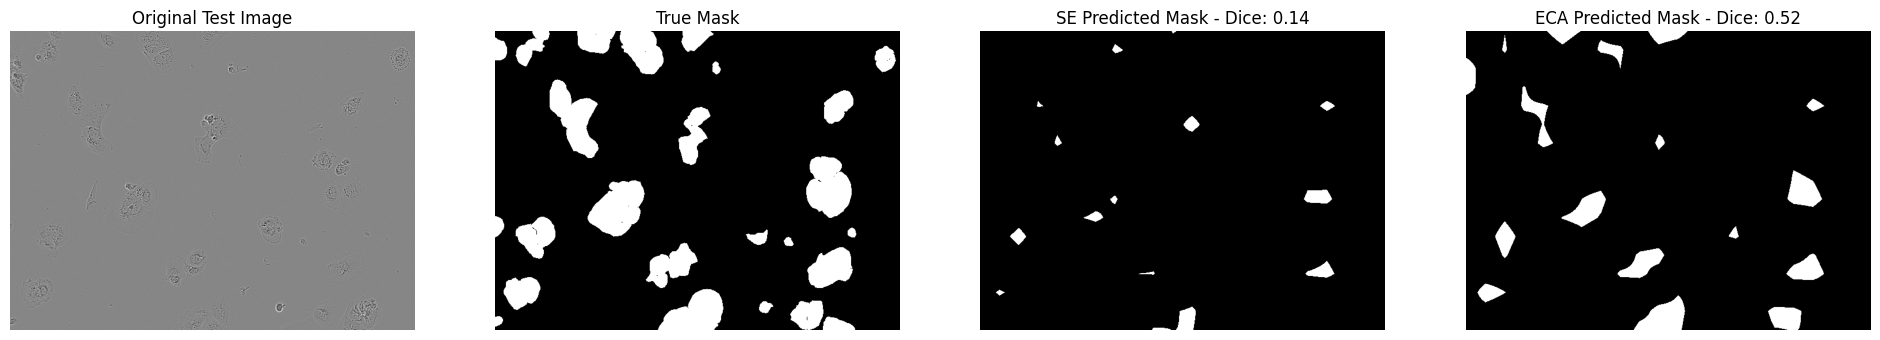

Evaluation complete!


In [48]:
for i_batch, sample_batched in enumerate(test_data_loader):
    with torch.no_grad():  # No need to track gradients for visualization
        image = sample_batched['image'][0].to(device)  # Send to device
        mask = sample_batched['annotations'][0].to(device)  # Send to device

        # Add batch dimension
        image_tensor = image.unsqueeze(0)

        # Get predictions from both models
        predicted_mask_tensor_se = model_se(image_tensor)
        predicted_mask_tensor_eca = model_eca(image_tensor)

        # Apply sigmoid and threshold
        predicted_probs_tensor_se = torch.sigmoid(predicted_mask_tensor_se).squeeze(0)
        predicted_mask_np_se = (predicted_probs_tensor_se > 0.5).cpu().numpy().astype(np.uint8)

        predicted_probs_tensor_eca = torch.sigmoid(predicted_mask_tensor_eca).squeeze(0)
        predicted_mask_np_eca = (predicted_probs_tensor_eca > 0.5).cpu().numpy().astype(np.uint8)

        # Compute Dice scores
        mask_np = mask.cpu().numpy().astype(np.float)  # Ensure binary mask
        
        dice_score_se = dice_coefficient(mask_np.flatten(), predicted_mask_np_se.flatten())
        dice_score_eca = dice_coefficient(mask_np.flatten(), predicted_mask_np_eca.flatten())
        
        dice_SE.append(dice_score_se)
        dice_ECA.append(dice_score_eca)
        
        # Squeeze the mask for visualization if necessary
        mask_np_squeezed = np.squeeze(mask_np)
        predicted_mask_np_se_squeezed = np.squeeze(predicted_mask_np_se)
        predicted_mask_np_eca_squeezed = np.squeeze(predicted_mask_np_eca)

        # Plotting
        plt.figure(figsize=(24, 6))

        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')  # Ensure to squeeze channel dimension
        plt.axis('off')
        plt.title('Original Test Image')

        # True mask
        plt.subplot(1, 4, 2)
        plt.imshow(mask_np_squeezed, cmap='gray')
        plt.axis('off')
        plt.title('True Mask')

        # SE Predicted mask
        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask_np_se_squeezed, cmap='gray')
        plt.axis('off')
        plt.title(f'SE Predicted Mask - Dice: {dice_score_se:.2f}')

        # ECA Predicted mask
        plt.subplot(1, 4, 4)
        plt.imshow(predicted_mask_np_eca_squeezed, cmap='gray')
        plt.axis('off')
        plt.title(f'ECA Predicted Mask - Dice: {dice_score_eca:.2f}')

        plt.show()
        #plt.savefig(f'ECA_vs_SE/batch_{i_batch}.png')
        plt.close()  # Close to free memory
        break

print("Evaluation complete!")

## Efficient Channel Attention outperformed Squeeze and Excitation

In [67]:
print(f'Dice of Efficient Channel Attention {round(statistics.mean(dice_ECA),3)}')
print(f'Dice of Squeeze and Excitation {round(statistics.mean(dice_SE), 3)}')


Dice of Efficient Channel Attention 0.589
Dice of Squeeze and Excitation 0.301


In [70]:
print(f'Max Dice of Efficient Channel Attention {round(max(dice_ECA),3)}')
print(f'Max Dice of Squeeze and Excitation {round(max(dice_SE),3)}')

Max Dice of Efficient Channel Attention 0.751
Max Dice of Squeeze and Excitation 0.69


In [71]:
print(f'Min Dice of Efficient Channel Attention {round(min(dice_ECA),3)}')
print(f'Min Dice of Squeeze and Excitation {round(min(dice_SE),3)}')

Min Dice of Efficient Channel Attention 0.227
Min Dice of Squeeze and Excitation 0.055
